# 자동차 연비 예측

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%precision 3
%matplotlib inline

## 데이터 처리
### 원본 data파일을 불러와 공백제거 후 csv파일로 변환

In [2]:
import csv
f = open("auto-mpg.data", 'r')
ff = open('output.csv', 'w', encoding='utf-8', newline='')
wr = csv.writer(ff)
while 1:
    line = f.readline()
    if not line: break
    line=line[:-1]
    l=line.split('\t')
    l2=l[0].split(' ')
    while 1 :
        try :
            l2.remove('')
        except :
            break
    l2.append(l[1])
    wr.writerow(l2)
f.close()
ff.close()
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model_Year', 'Origin', 'Model_name']
data = pd.read_csv("output.csv", names=column_names)
data2 = pd.read_csv("2.csv")
data=data.dropna()
data.head(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,Model_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


### 단위변환 MPG, 1mile/gal=0.425km/L  //  Displacement, 1입방인치=16.39입방센치
### 필요없어진 MPG, Displacement, Origin 열 삭제 후 열 순서 조정

In [3]:
data['KPL']=data.MPG*0.425
data['cc']=data.Displacement*16.39
data['Model_Year'] = 1900+data.Model_Year
data.drop(['MPG', 'Displacement', 'Origin'],axis=1 , inplace=True)
data = data[['KPL', 'Cylinders', 'cc', 'Horsepower', 'Weight', 'Acceleration', 'Model_Year', 'Model_name']]
data.head(5)

,KPL,Cylinders,cc,Horsepower,Weight,Acceleration,Model_Year,Model_name
0,7.650,8,5031.73,130.0,3504.0,12.0,1970,"""chevrolet chevelle malibu"""
1,6.375,8,5736.50,165.0,3693.0,11.5,1970,"""buick skylark 320"""
2,7.650,8,5212.02,150.0,3436.0,11.0,1970,"""plymouth satellite"""
3,6.800,8,4982.56,150.0,3433.0,12.0,1970,"""amc rebel sst"""
4,7.225,8,4949.78,140.0,3449.0,10.5,1970,"""ford torino"""


### Horsepower에 특수문자가 포함된 행 제거

In [4]:
t=[]
for i in range(len(data)) :
    try :
        float(data.Horsepower.iloc[i])
    except :
        t.append(i)
data.drop(index=t, inplace=True)
data['Horsepower'] = pd.to_numeric(data['Horsepower'])
data.head(5)

,KPL,Cylinders,cc,Horsepower,Weight,Acceleration,Model_Year,Model_name
0,7.650,8,5031.73,130.0,3504.0,12.0,1970,"""chevrolet chevelle malibu"""
1,6.375,8,5736.50,165.0,3693.0,11.5,1970,"""buick skylark 320"""
2,7.650,8,5212.02,150.0,3436.0,11.0,1970,"""plymouth satellite"""
3,6.800,8,4982.56,150.0,3433.0,12.0,1970,"""amc rebel sst"""
4,7.225,8,4949.78,140.0,3449.0,10.5,1970,"""ford torino"""


In [5]:
data3 = pd.concat([data,data2], axis=0)
data3.dropna(inplace=True)
data3

,KPL,Cylinders,cc,Horsepower,Weight,Acceleration,Model_Year,Model_name
0,7.650,8,5031.73,130.0,3504.0,12.0,1970,"""chevrolet chevelle malibu"""
1,6.375,8,5736.50,165.0,3693.0,11.5,1970,"""buick skylark 320"""
2,7.650,8,5212.02,150.0,3436.0,11.0,1970,"""plymouth satellite"""
3,6.800,8,4982.56,150.0,3433.0,12.0,1970,"""amc rebel sst"""
4,7.225,8,4949.78,140.0,3449.0,10.5,1970,"""ford torino"""
...,...,...,...,...,...,...,...,...
34,16.900,4,999.00,45.0,729.0,17.7,1990,Fiat Uno
35,9.300,6,3791.00,165.0,1619.0,11.3,1990,Buick Raetta
36,11.800,4,1360.00,75.0,1100.0,17.3,1990,Berlingo
37,14.900,4,1242.00,60.0,835.0,13.3,1990,Epsilon


In [6]:
data3.describe()

,KPL,Cylinders,cc,Horsepower,Weight,Acceleration,Model_Year
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,10.046845,5.464037,3150.317181,115.707657,2851.287703,14.992807,1978.570766
std,3.281330,1.810302,1702.584626,71.828529,911.930442,3.355125,9.543242
min,3.825000,3.000000,796.000000,41.000000,630.000000,2.500000,1970.000000
25%,7.480000,4.000000,1720.950000,76.500000,2130.000000,13.250000,1973.000000
50%,9.775000,4.000000,2474.890000,95.000000,2672.000000,15.100000,1977.000000
75%,12.325000,7.000000,4261.400000,140.500000,3512.000000,17.000000,1980.000000
max,19.805000,16.000000,7993.000000,1001.000000,5140.000000,24.800000,2020.000000


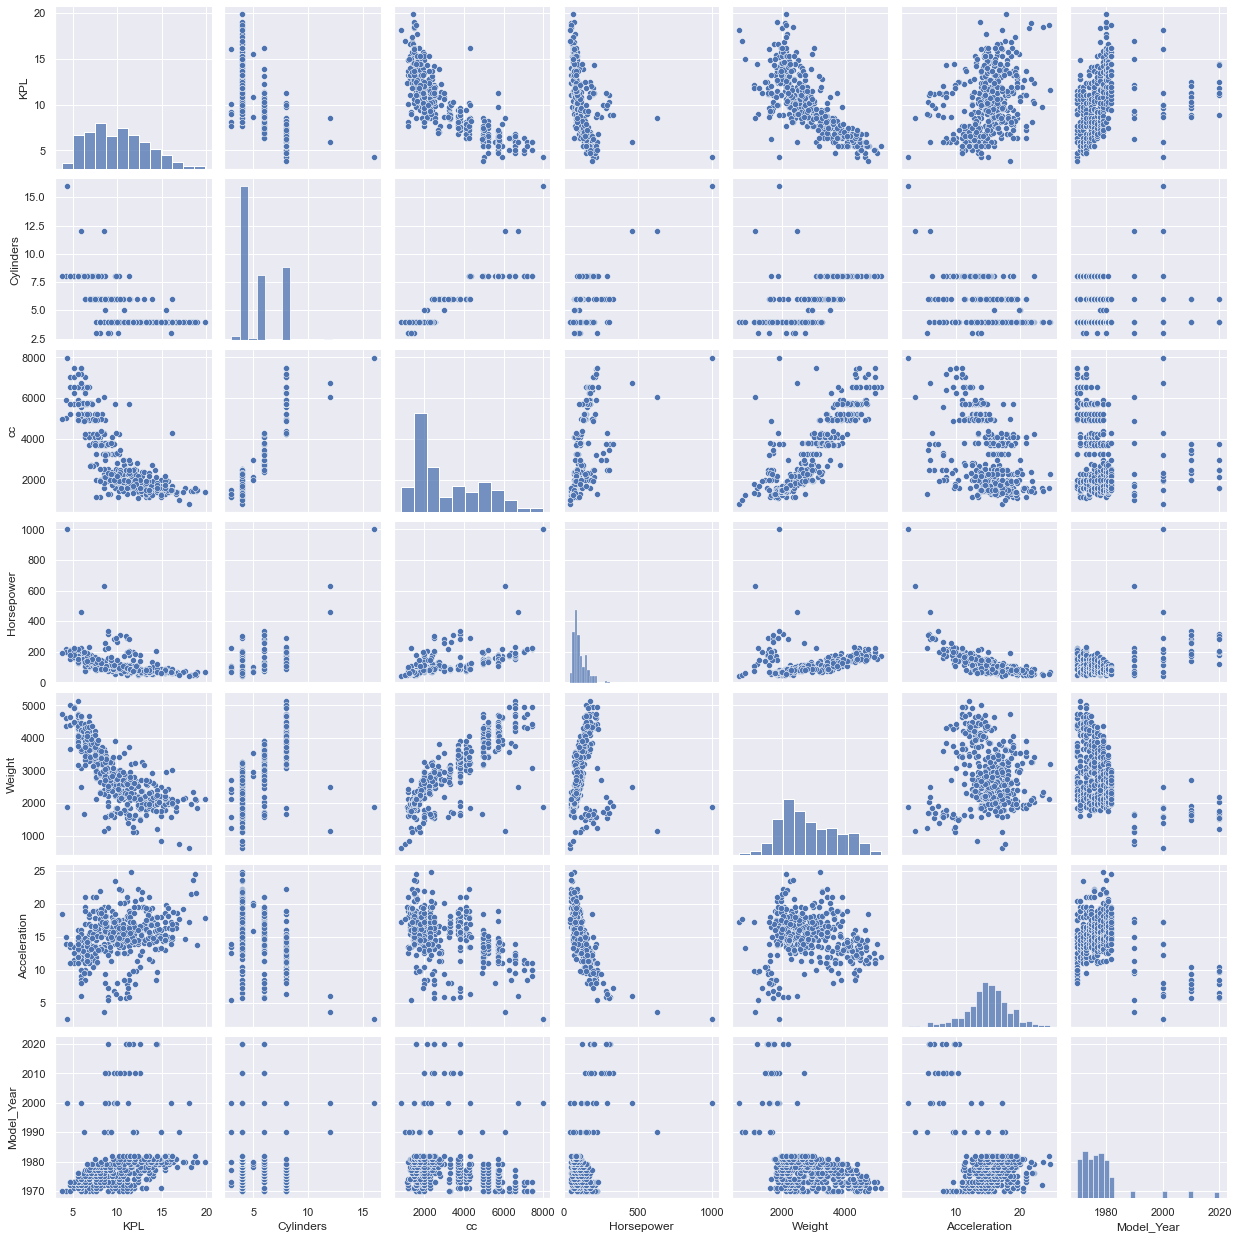

In [7]:
sns.pairplot(data3) #

In [8]:
data3.corr()

,KPL,Cylinders,cc,Horsepower,Weight,Acceleration,Model_Year
KPL,1.000000,-0.748010,-0.804621,-0.463902,-0.768863,0.326475,0.283952
Cylinders,-0.748010,1.000000,0.934023,0.653787,0.743509,-0.428062,-0.150383
cc,-0.804621,0.934023,1.000000,0.573144,0.844339,-0.432177,-0.193485
Horsepower,-0.463902,0.653787,0.573144,1.000000,0.212201,-0.706776,0.369897
Weight,-0.768863,0.743509,0.844339,0.212201,1.000000,-0.083666,-0.460766
Acceleration,0.326475,-0.428062,-0.432177,-0.706776,-0.083666,1.000000,-0.407794
Model_Year,0.283952,-0.150383,-0.193485,0.369897,-0.460766,-0.407794,1.000000


## 가능한 모든 모델을 만들어서 최소값의 AIC 찾기

In [9]:
stR="KPL ~ " #모델의 종속변수와 독립변수 조합을 지정하는 변수
c1=[] #각 모델의 AIC 값 넣는 리스트
c2=[] #각 모델의 종속변수와 독립변수 조합을 저장하는 리스트
for i in range(2) : #6중 for 문으로 0과 1 상태에 따라 조합을 다르게 하기 위함 -> 2**6=32 모든 경우 계산
    if i%2==0 :
        t1=stR #for 문이 한번 끝나고 stR을 이전 상태로 돌리기 위해 저장함
        stR+="+Cylinders" #모델에 Cylinders 독립변수가 있는 경우의 모델을 만들기 위함
    else :
        stR=t1 #Cylinders 독립변수가 없는 경우의 모델을 만들기 위함
    for j in range(2) : #반복
        if j%2==0 :
            t2=stR
            stR+="+cc"
        else :
            stR=t2
        for k in range(2) :
            if k%2==0 :
                t3=stR
                stR+="+Horsepower"
            else :
                stR=t3
            for l in range(2) :
                if l%2==0 :
                    t4=stR
                    stR+="+Weight"
                else :
                    stR=t4
                for n in range(2) :
                    if n%2==0 :
                        t5=stR
                        stR+="Acceleration"
                    else :
                        stR=t5
                    for m in range(2) :
                        if m%2==0 :
                            t6=stR
                            stR+="+Model_Year"
                        else :
                            stR=t6
                        try :
                            t7=smf.ols(formula = stR, data = data3).fit() #stR로 모든 조합을 만듬
                            c1.append(t7.aic.round(3))
                        except :
                            t7=smf.ols(formula = "KPL ~ 1", data = data3).fit()
                            c1.append(t7.aic.round(3))
                        c2.append(stR)
print(c1)
print(c2)
c2[c1.index(min(c1))]

[2248.394, 2248.394, 1730.54, 1745.958, 2248.394, 2248.394, 1769.044, 1804.896, 2248.394, 2248.394, 1767.959, 1768.343, 2248.394, 2248.394, 1783.672, 1802.974, 2248.394, 2248.394, 1741.193, 1752.378, 2248.394, 2248.394, 1860.624, 1897.941, 2248.394, 2248.394, 1788.489, 1786.543, 2248.394, 2248.394, 1868.536, 1897.022, 2248.394, 2248.394, 1730.893, 1744.35, 2248.394, 2248.394, 1770.173, 1803.08, 2248.394, 2248.394, 1766.996, 1767.569, 2248.394, 2248.394, 1781.675, 1801.093, 2248.394, 2248.394, 1740.524, 1753.325, 2248.394, 2248.394, 1990.297, 2145.949, 2248.394, 2248.394, 1860.236, 1864.904, 2089.176, 2201.818, 2214.162, 2248.394]
['KPL ~ +Cylinders+cc+Horsepower+WeightAcceleration+Model_Year', 'KPL ~ +Cylinders+cc+Horsepower+WeightAcceleration', 'KPL ~ +Cylinders+cc+Horsepower+Weight+Model_Year', 'KPL ~ +Cylinders+cc+Horsepower+Weight', 'KPL ~ +Cylinders+cc+HorsepowerAcceleration+Model_Year', 'KPL ~ +Cylinders+cc+HorsepowerAcceleration', 'KPL ~ +Cylinders+cc+Horsepower+Model_Year', 'KP

'KPL ~ +Cylinders+cc+Horsepower+Weight+Model_Year'

## Cylinders, cc, Horsepower, Weight, Model_Year 조합이 가장 AIC 값이 낮았지만 Cylinders의 p값이 높아 Cylinders를 뺀 모델을 알아보니 AIC값이 같아서 cc, Horsepower, Weight, Model_Year를 적용하였다.

In [10]:
model=smf.ols(formula ="KPL ~ Cylinders+cc+Horsepower+Weight+Model_Year", data = data3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KPL   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     204.3
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.32e-110
Time:                        22:42:27   Log-Likelihood:                -859.27
No. Observations:                 431   AIC:                             1731.
Df Residuals:                     425   BIC:                             1755.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -85.6750     24.707     -3.468      0.001    -134.239     -37.111
Cylinders      0.2280      0.149      1.525      0.128      -0.066       0.522
cc            -0.0007      0.000     -3.558      0.000      -0.001      -0.000
Horsepower    -0.0140      0.002     -6.380      0.000      -0.018      -0.010
Weight        -0.0015      0.000     -6.471      0.000      -0.002      -0.001
Model_Year     0.0519      0.012      4.187      0.000       0.028       0.076
==============================================================================
Omnibus:                       51.142   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.660
Skew:                           0.799   Prob(JB):                     6.13e-17
Kurtosis:                       4.266   Cond. No.                     1.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
model=smf.ols(formula ="KPL ~ cc+Horsepower+Weight+Model_Year", data = data3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KPL   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     254.0
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          2.46e-111
Time:                        22:42:28   Log-Likelihood:                -860.45
No. Observations:                 431   AIC:                             1731.
Df Residuals:                     426   BIC:                             1751.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -77.0594     24.090     -3.199      0.001    -124.410     -29.709
cc            -0.0005      0.000     -3.414      0.001      -0.001      -0.000
Horsepower    -0.0127      0.002     -6.275      0.000      -0.017      -0.009
Weight        -0.0016      0.000     -6.544      0.000      -0.002      -0.001
Model_Year     0.0478      0.012      3.944      0.000       0.024       0.072
==============================================================================
Omnibus:                       53.062   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.931
Skew:                           0.802   Prob(JB):                     2.67e-18
Kurtosis:                       4.390   Cond. No.                     1.39e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 테스트 데이터 예측 결과

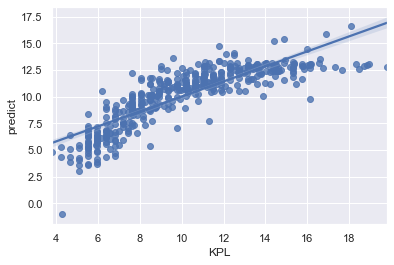

In [12]:
data3['predict']=model.predict(data3)
sns.regplot(x='KPL', y='predict', data=data3)

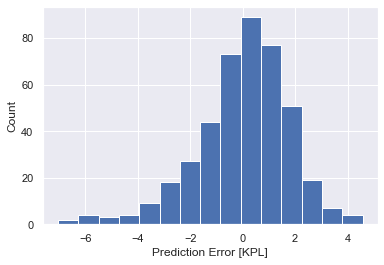

In [14]:
data3['error'] = data3.predict - data3.KPL
plt.hist(data3['error'], bins = 15)
plt.xlabel("Prediction Error [KPL]")
_ = plt.ylabel("Count")

### 오차의 절댓값을 내림차순으로 정렬

In [15]:
data3['abs']=abs(data3.error)
data3.sort_values(by=['abs'], axis=0, ascending=False, inplace=True)
data3.head(15)

,KPL,Cylinders,cc,Horsepower,Weight,Acceleration,Model_Year,Model_name,predict,error,abs
322,19.8050,4,1409.54,65.0,2110.0,17.9,1980,"""mazda glc""",12.762517,-7.042483,7.042483
387,16.1500,6,4294.18,85.0,3015.0,17.0,1982,"""oldsmobile cutlass ciera (diesel)""",9.785202,-6.364798,6.364798
329,18.9550,4,1491.49,67.0,1850.0,13.8,1980,"""honda civic 1500 gl""",13.099903,-5.855097,5.855097
326,18.4450,4,1475.10,48.0,2335.0,23.7,1980,"""vw dasher (diesel)""",12.597387,-5.847613,5.847613
325,18.8275,4,1475.10,48.0,2085.0,21.7,1980,"""vw rabbit c (diesel)""",12.984896,-5.842604,5.842604
394,18.7000,4,1589.83,52.0,2130.0,24.6,1982,"""vw pickup""",12.903604,-5.796396,5.796396
21,4.3000,16,7993.00,1001.0,1888.0,2.5,2000,Bugatti Veyron 16.4,-1.052323,-5.352323,5.352323
244,18.3175,4,1475.10,48.0,1985.0,21.5,1978,"""volkswagen rabbit custom diesel""",13.044334,-5.273166,5.273166
309,17.6375,4,1606.22,76.0,2144.0,14.7,1980,"""vw rabbit""",12.473612,-5.163888,5.163888
324,17.3400,4,1393.15,65.0,2110.0,19.2,1980,"""datsun 210""",12.770563,-4.569437,4.569437


### 디젤 차량에 대해서는 예측이 힘들고 고마력, 고배기량이지만 가벼운 슈퍼카에 대해서도 예측이 어렵다는 것을 알 수 있다. 차량 데이터 컬럼에 차종, 연료의 종류를 구분하는 데이터가 있었다면 예측 정확도가 높아질 것이다.